In [19]:
import pandas as pd
from datetime import datetime

# Function to convert date from dd-mm-yyyy format and extract year and month
def convert_date_to_month(date_value):
    try:
        # Convert to datetime, ignoring errors to handle invalid dates
        date_converted = pd.to_datetime(date_value, format='%d-%m-%Y', errors='coerce')
        return date_converted.to_period('M') if pd.notnull(date_converted) else pd.NaT
    except Exception as e:
        print(f"Error parsing date: {date_value}. Error: {e}")
        return pd.NaT

# Load the wheat price data
wheat_price_df = pd.read_csv('wheatprice.csv')

# Convert date to month-year format
wheat_price_df['Month'] = wheat_price_df['date'].apply(convert_date_to_month)

# Drop rows with invalid or missing dates
wheat_price_df = wheat_price_df.dropna(subset=['Month'])

# Initialize the combined DataFrame
combined_df = pd.DataFrame()

# List of cities
cities = ['MUMBAI', 'KOLKATA', 'HYDERABAD', 'BENGALURU', 'CHENNAI', 'DELHI', 'AHMEDABAD']

# Merge weather data for each city
for city in cities:
    weather_file = f'{city.lower()}.csv'
    
    # Load the weather data
    weather_df = pd.read_csv(weather_file)
    
    # Convert the date to month-year format
    weather_df['Month'] = weather_df['date'].apply(convert_date_to_month)
    
    # Drop rows with invalid or missing dates
    weather_df = weather_df.dropna(subset=['Month'])
    
    # Ensure numeric data for aggregation
    weather_df['tmax'] = pd.to_numeric(weather_df['tmax'], errors='coerce')
    weather_df['tmin'] = pd.to_numeric(weather_df['tmin'], errors='coerce')
    weather_df['rain'] = pd.to_numeric(weather_df['rain'], errors='coerce')
    
    # Group by month and calculate the average max temp, min temp, and total rainfall
    weather_agg = weather_df.groupby('Month').agg({
        'tmax': 'mean',
        'tmin': 'mean',
        'rain': 'sum'
    }).reset_index()
    
    # Add city information to the aggregated weather data
    weather_agg['centre'] = city.upper()
    
    # Merge the wheat price data and aggregated weather data based on month and city
    merged_df = pd.merge(
        wheat_price_df[wheat_price_df['centre'] == city], 
        weather_agg, 
        on=['Month', 'centre'], 
        how='inner'
    )
    
    # Append to the combined DataFrame
    combined_df = pd.concat([combined_df, merged_df], ignore_index=True)

# Verify the final combined dataset
print(f"Total combined rows: {len(combined_df)}")
print(combined_df.head())

# Save the final combined data to an Excel file
combined_df.to_excel('combined_wheat_weather_data_by_month.xlsx', index=False)

print("Data combined successfully and saved to 'combined_wheat_weather_data_by_month.xlsx'")


Total combined rows: 7754
         date  centre   price     msp    Month       tmax       tmin  rain
0  09-03-2009  MUMBAI  1500.0  1080.0  2009-03  35.287097  19.933549   0.0
1  18-03-2009  MUMBAI  1475.0  1080.0  2009-03  35.287097  19.933549   0.0
2  25-03-2009  MUMBAI  1425.0  1080.0  2009-03  35.287097  19.933549   0.0
3  01-04-2009  MUMBAI  1300.0  1080.0  2009-04  37.269334  23.209333   0.0
4  08-04-2009  MUMBAI  1300.0  1080.0  2009-04  37.269334  23.209333   0.0
Data combined successfully and saved to 'combined_wheat_weather_data_by_month.xlsx'


In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('combined_wheat_weather_data_by_month.csv')

# Convert 'date' to datetime format and extract necessary components
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

# One-Hot Encode 'centre' (city)

onehot_encoder = OneHotEncoder(sparse_output=False)  # Updated here
city_encoded = onehot_encoder.fit_transform(df[['centre']])

# Append encoded city data to dataframe
df_city_encoded = pd.DataFrame(city_encoded, columns=onehot_encoder.categories_[0])
df = pd.concat([df, df_city_encoded], axis=1)

# Features and target
features = ['msp', 'rain', 'tmax', 'tmin'] + list(df_city_encoded.columns)  # Include city columns
X = df[features]
y = df['price']

# Scaling the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (without shuffling)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Reshape input for LSTM (LSTM expects 3D input: samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(150, return_sequences=True, input_shape=(1, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(150, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

# Evaluate the model
y_pred = model.predict(X_test)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Inverse scaling the predictions and actual values
y_test = y_test.values.reshape(-1, 1)
y_pred = y_pred.reshape(-1, 1)

# Recreate full dataset to inverse transform only price column
X_test_full = np.hstack((y_test, np.zeros((y_test.shape[0], X_scaled.shape[1] - 1))))
y_test_inv = scaler.inverse_transform(X_test_full)[:, 0]

X_pred_full = np.hstack((y_pred, np.zeros((y_pred.shape[0], X_scaled.shape[1] - 1))))
y_pred_inv = scaler.inverse_transform(X_pred_full)[:, 0]

# Plot the results (x-axis with dates)
plt.figure(figsize=(14, 7))
dates = df['date'].iloc[-len(y_test):]  # Ensure dates are aligned with test data
plt.plot


Epoch 1/100


C:\Users\abde manaf\anaconda3-2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 4214731.5000 - val_loss: 1963358.2500
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4093154.0000 - val_loss: 1898159.2500
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3981939.2500 - val_loss: 1839985.7500
Epoch 4/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3903513.7500 - val_loss: 1784653.5000
Epoch 5/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3823110.7500 - val_loss: 1731318.8750
Epoch 6/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3728829.7500 - val_loss: 1679575.1250
Epoch 7/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3658742.7500 - val_loss: 1628944.8750
Epoch 8/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3610210.7500 - val_loss: 1579637.6250
Epoch 9/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3523903.5000 - val_loss: 1531329.7500
Epoch 10/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3447866.5000 - val_loss: 1484102.2500
Epoch 11/100
175/175

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

<Figure size 1400x700 with 0 Axes>

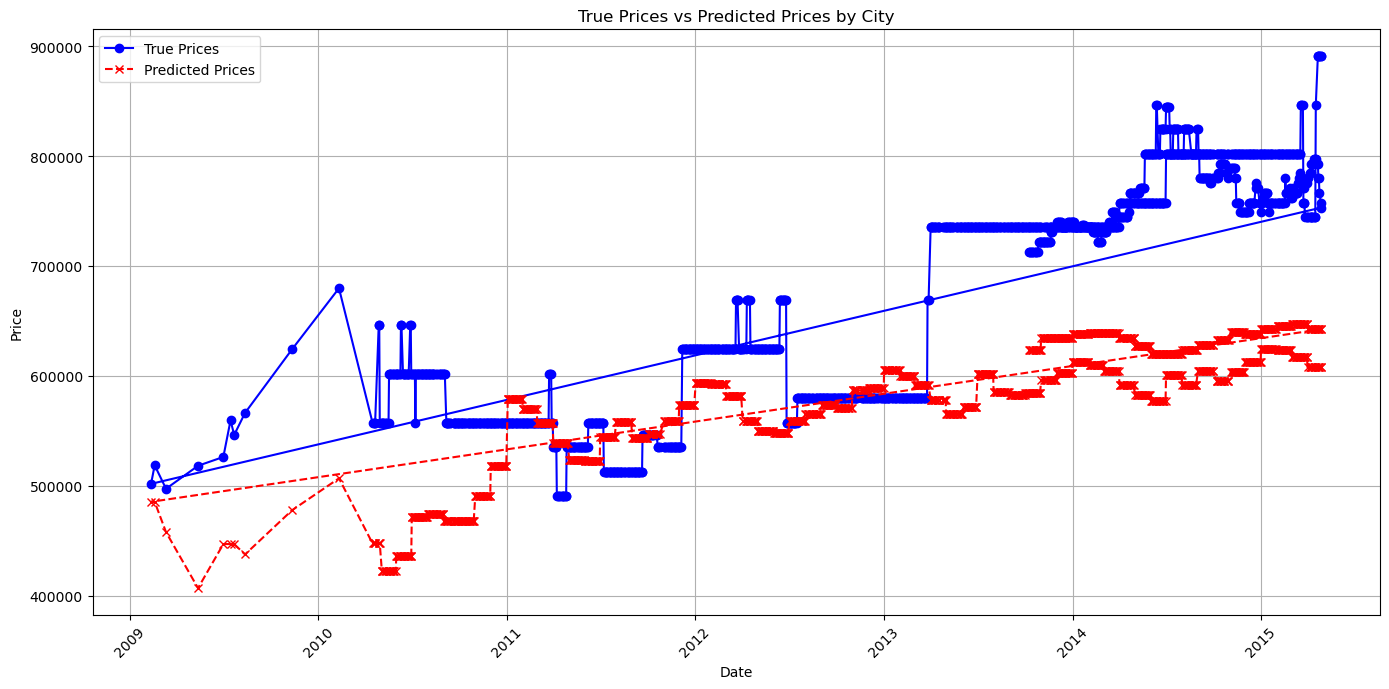

In [33]:
# Plot the results (x-axis with dates)
plt.figure(figsize=(14, 7))  # Set the figure size
dates = df['date'].iloc[-len(y_test):].values  # Ensure dates are aligned with test data

plt.plot(dates, y_test_inv, label='True Prices', color='blue', linestyle='-', marker='o')  # True prices
plt.plot(dates, y_pred_inv, label='Predicted Prices', color='red', linestyle='--', marker='x')  # Predicted prices

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('True Prices vs Predicted Prices by City')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend()
plt.grid(True)  # Add grid for better visualization
plt.tight_layout()

# Show the plot
plt.show()


No test data available for city: MUMBAI
No test data available for city: KOLKATA
No test data available for city: HYDERABAD
No test data available for city: BENGALURU
No test data available for city: CHENNAI


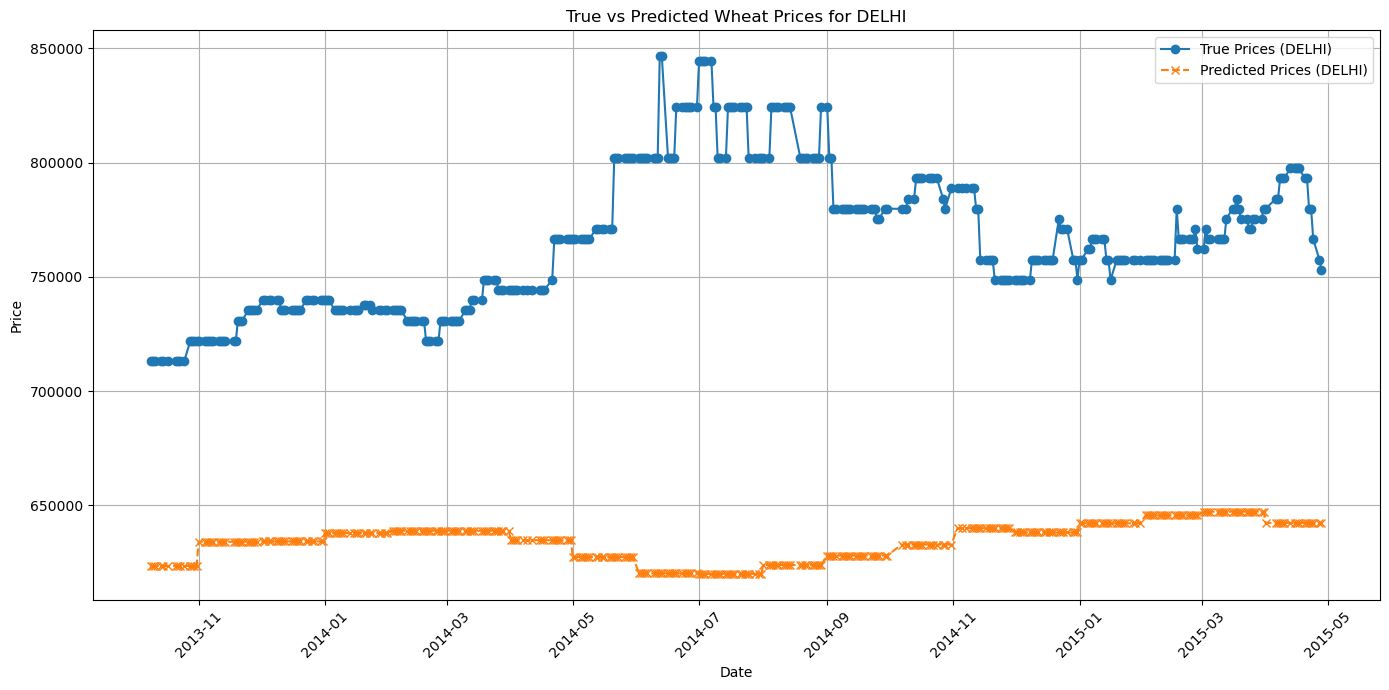

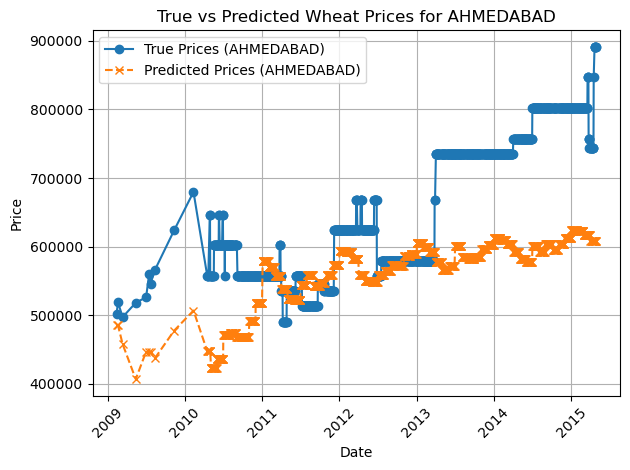

In [37]:
# Group the test data by city
cities = df['centre'].unique()  # List of unique cities

# Get the test indices based on the original dataset's length
test_indices = df.index[-len(y_test):]

# Create a dictionary to store city-wise results
city_results = {}

# Prepare the figure size for better plotting
plt.figure(figsize=(14, 7))

# Loop through each city and plot city-specific data
for city in cities:
    # Get the test data for the specific city
    city_data = df.loc[test_indices]
    city_test_data = city_data[city_data['centre'] == city]

    # Check if there's enough data for the city in the test set
    if not city_test_data.empty:
        # Get the corresponding indices in the test set for the city
        city_test_indices = city_test_data.index - test_indices[0]  # Adjust for relative indexing

        # Get dates, true prices, and predicted prices for the city
        city_dates = city_test_data['date'].values
        city_y_test_inv = y_test_inv[city_test_indices]  # True prices for the city
        city_y_pred_inv = y_pred_inv[city_test_indices]  # Predicted prices for the city

        # Plot true vs. predicted prices for the city
        plt.plot(city_dates, city_y_test_inv, label=f'True Prices ({city})', linestyle='-', marker='o')
        plt.plot(city_dates, city_y_pred_inv, label=f'Predicted Prices ({city})', linestyle='--', marker='x')

        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title(f'True vs Predicted Wheat Prices for {city}')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        # Show the plot for each city
        plt.show()
    else:
        print(f"No test data available for city: {city}")



Processing city: MUMBAI


C:\Users\abde manaf\anaconda3-2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0899 - val_loss: 0.0034
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0050 - val_loss: 0.0015
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0028 - val_loss: 7.5748e-04
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0035 - val_loss: 8.0221e-04
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0025 - val_loss: 0.0037
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0027 - val_loss: 7.9584e-04
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step

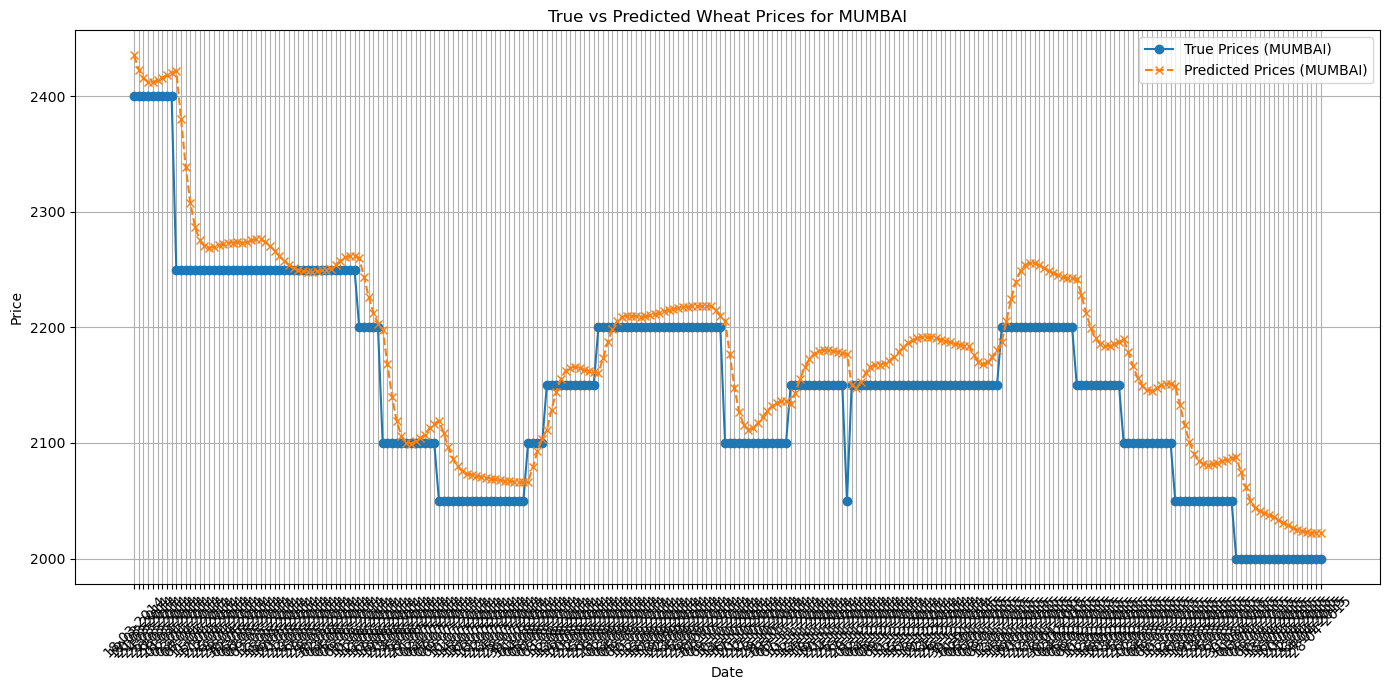

Mean Absolute Percentage Error (MAPE) for MUMBAI: 0.01%

Processing city: KOLKATA
Not enough data for KOLKATA. Skipping.

Processing city: HYDERABAD
Epoch 1/50


C:\Users\abde manaf\anaconda3-2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.1153 - val_loss: 0.0073
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0056 - val_loss: 0.0023
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0038 - val_loss: 9.2279e-04
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0030 - val_loss: 4.5379e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0027 - val_loss: 2.4743e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0027 - val_loss: 2.2545e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0025 - val_loss: 2.6616e-04
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0025 - val_loss: 4.6486e-04
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0024 - val_loss: 3.3552e-04
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0027 - val_loss: 2.4797e-04
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0019 - val_loss: 2.2167e-04
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━

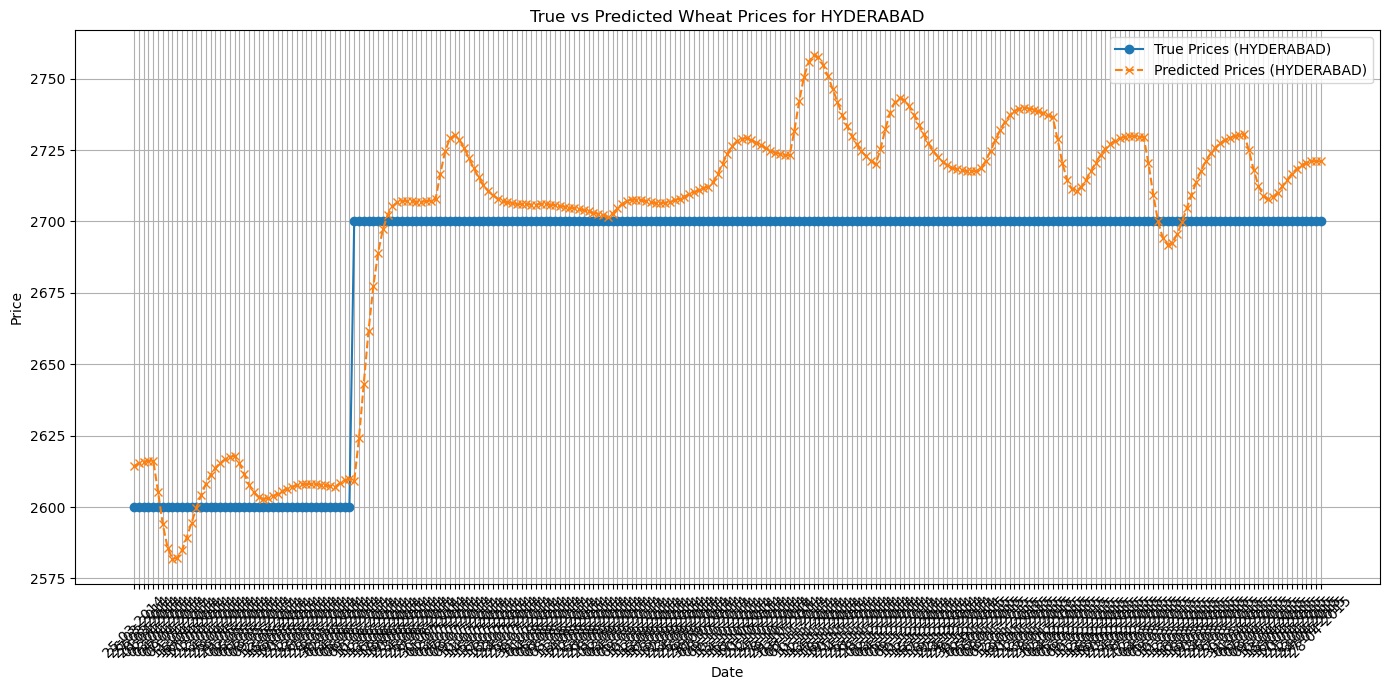

Mean Absolute Percentage Error (MAPE) for HYDERABAD: 0.01%

Processing city: BENGALURU
Epoch 1/50


C:\Users\abde manaf\anaconda3-2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.0520 - val_loss: 0.0094
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0040 - val_loss: 0.0051
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0027 - val_loss: 0.0056
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0024 - val_loss: 0.0046
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0022 - val_l

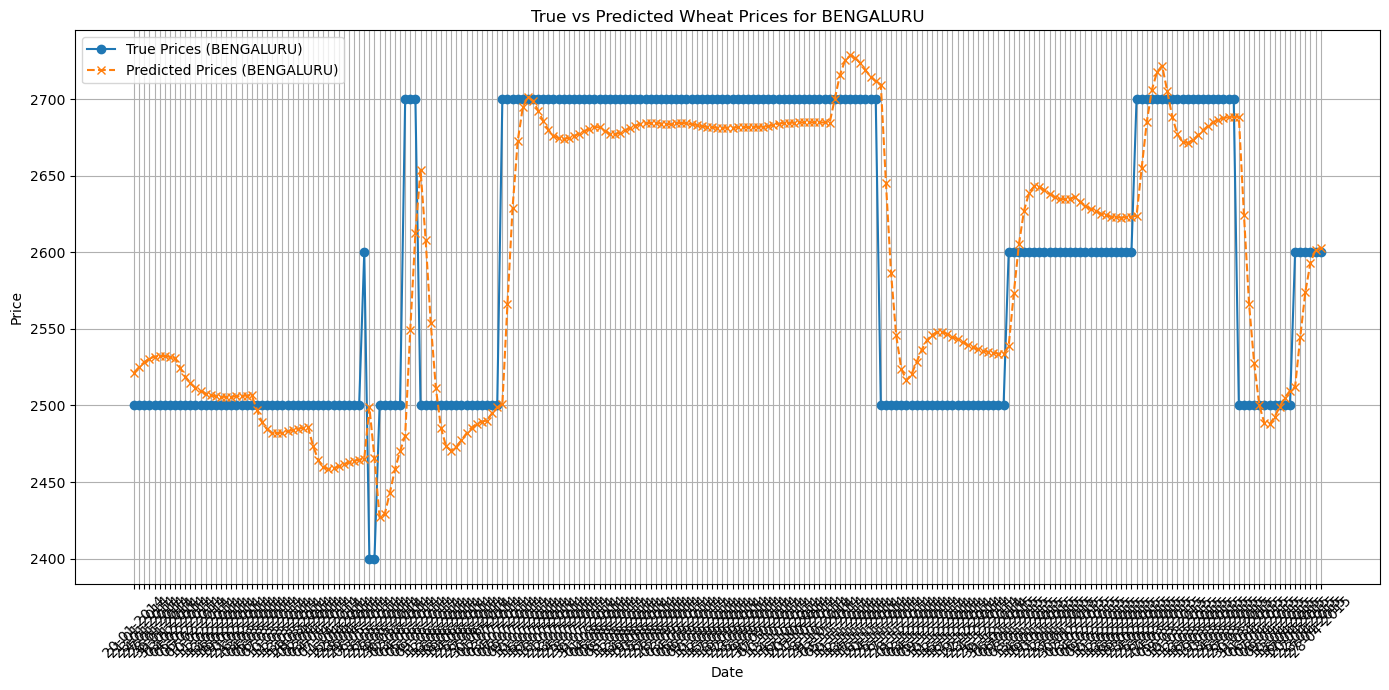

Mean Absolute Percentage Error (MAPE) for BENGALURU: 0.01%

Processing city: CHENNAI
Epoch 1/50


C:\Users\abde manaf\anaconda3-2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0827 - val_loss: 0.0050
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0050 - val_loss: 0.0054
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0047 - val_loss: 0.0037
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0044 - val_loss: 0.0034
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0035 - val_loss: 0.0043
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0032 - val_loss: 0.0048
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0028 - val_loss: 0.0041
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0027 - val_loss: 0.0032
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0026 - val_l

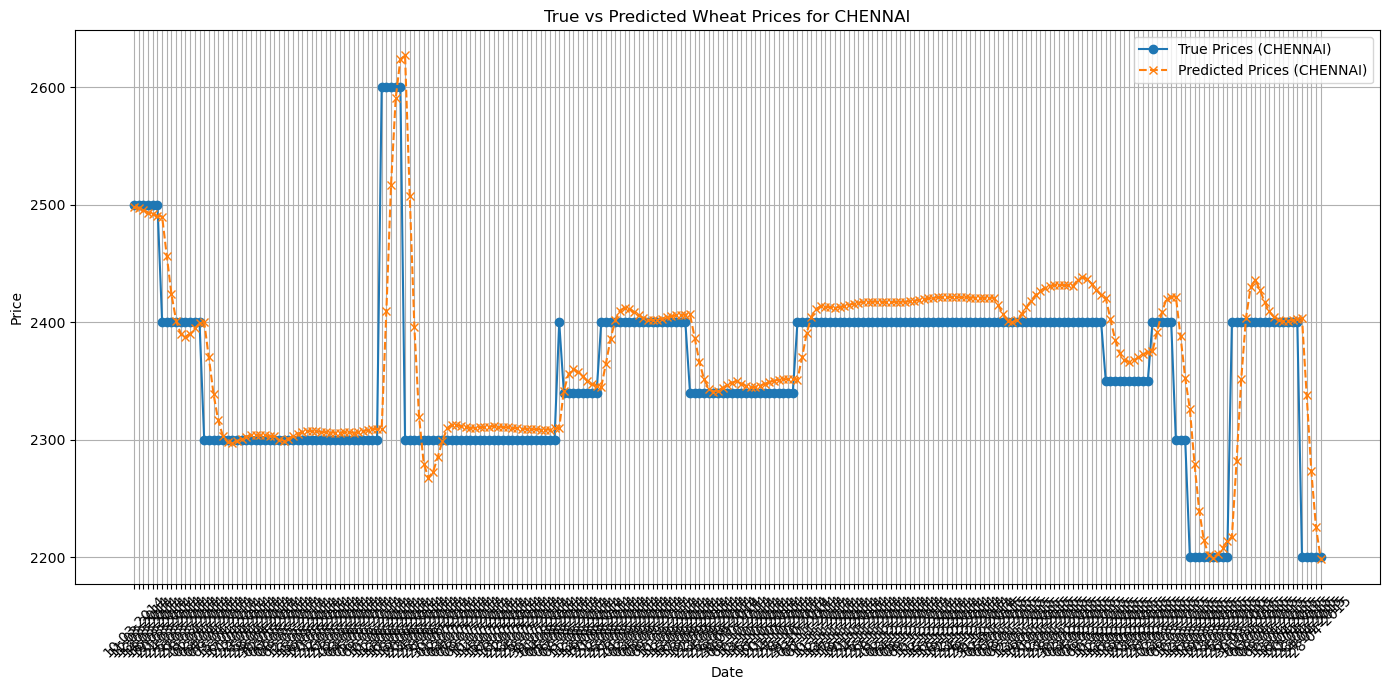

Mean Absolute Percentage Error (MAPE) for CHENNAI: 0.01%

Processing city: DELHI
Epoch 1/50


C:\Users\abde manaf\anaconda3-2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 0.0448 - val_loss: 0.0041
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0017 - val_l

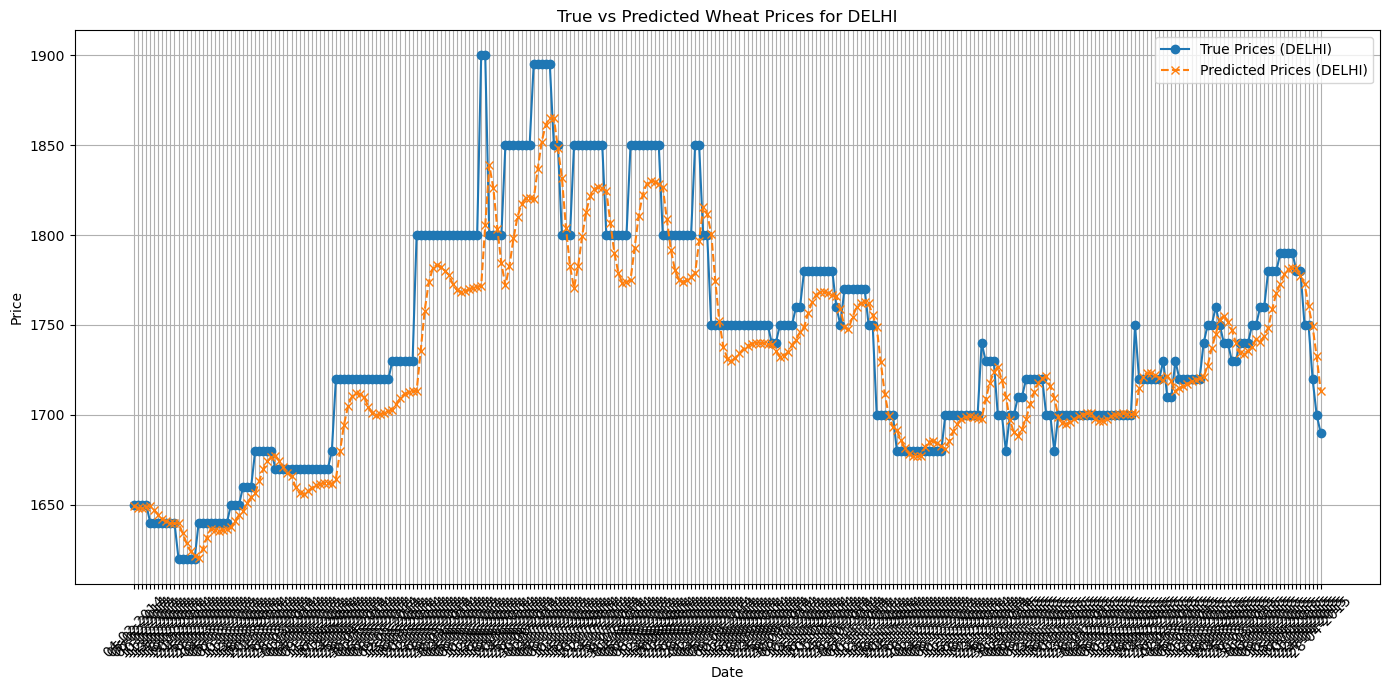

Mean Absolute Percentage Error (MAPE) for DELHI: 0.01%

Processing city: AHMEDABAD
Epoch 1/50


C:\Users\abde manaf\anaconda3-2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0533 - val_loss: 0.0283
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0051 - val_loss: 0.0035
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0026 - val_loss: 0.0046
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0025 - val_loss: 0.0037
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0017 - val_l

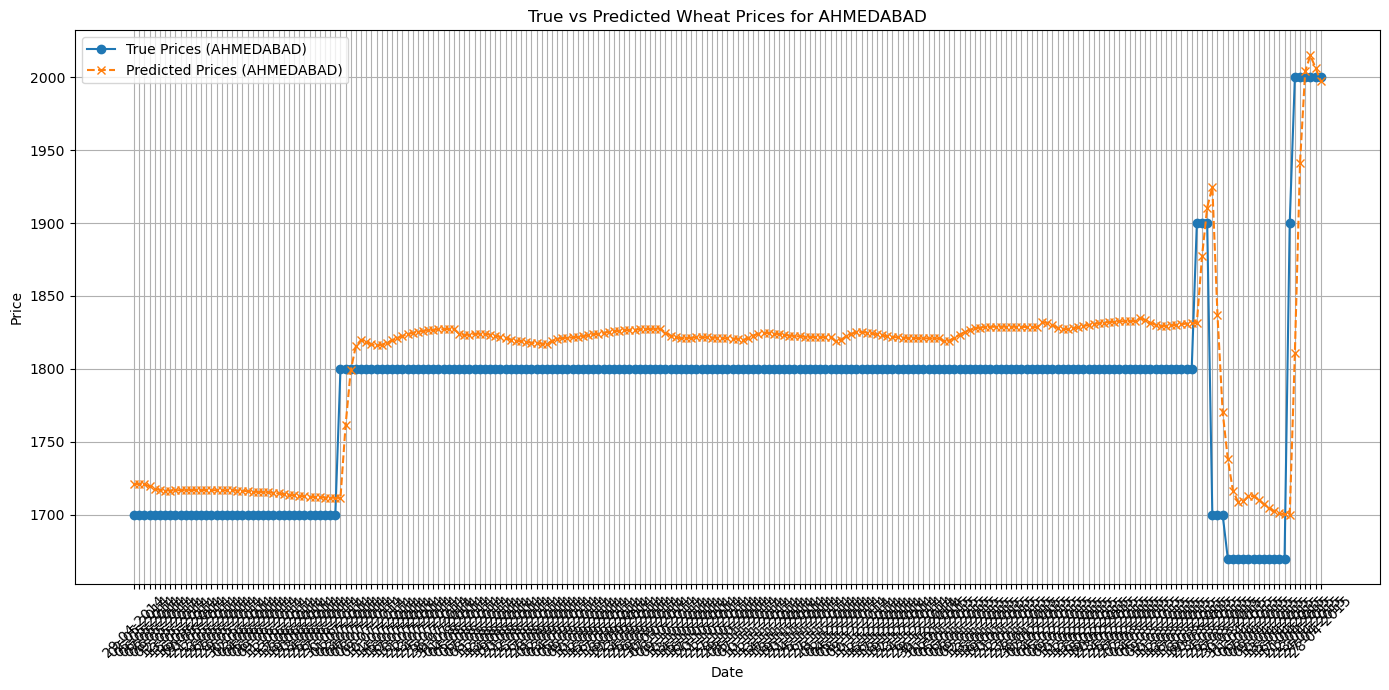

Mean Absolute Percentage Error (MAPE) for AHMEDABAD: 0.02%


In [41]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Load your combined dataset
df = pd.read_excel('combined_wheat_weather_data_by_month.xlsx')

# List of cities
cities = df['centre'].unique()

# Function to prepare dataset for LSTM
def create_lstm_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step, 0])  # Assuming price is the first column
    return np.array(X), np.array(y)

# Function to create and train LSTM model
def train_lstm(X_train, y_train, X_val, y_val, time_step):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
    model.add(Dropout(0.1))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)
    
    return model

# Train and predict for each city
for city in cities:
    print(f"\nProcessing city: {city}")
    
    # Filter data for the city
    city_data = df[df['centre'] == city].copy()

    # Handle missing values if necessary
    city_data = city_data.dropna()
    
    # Check if there are enough samples
    if len(city_data) < 2 * time_step:
        print(f"Not enough data for {city}. Skipping.")
        continue
    
    # Features and labels (assuming 'price' is the label)
    features = ['msp', 'rain', 'tmax', 'tmin']
    X = city_data[features].values
    y = city_data['price'].values.reshape(-1, 1)

    # Normalize the features
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)

    # Create LSTM dataset with time step
    time_step = 30  # Adjust as needed
    X_lstm, y_lstm = create_lstm_dataset(np.hstack((y_scaled, X_scaled)), time_step)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, shuffle=False)
    
    # Train the model
    model = train_lstm(X_train, y_train, X_test, y_test, time_step)
    
    # Predictions
    y_pred_scaled = model.predict(X_test)

    # Inverse transform the predictions and actual values
    y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))
    y_pred_inv = scaler_y.inverse_transform(y_pred_scaled)

    # Prepare dates for plotting
    dates = city_data['date'].iloc[-len(y_test):].values

    # Plot the results
    plt.figure(figsize=(14, 7))
    plt.plot(dates, y_test_inv, label=f'True Prices ({city})', marker='o')
    plt.plot(dates, y_pred_inv, label=f'Predicted Prices ({city})', linestyle='--', marker='x')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'True vs Predicted Wheat Prices for {city}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Calculate and print MAPE
    mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
    print(f"Mean Absolute Percentage Error (MAPE) for {city}: {mape:.2f}%")


Columns in dataset: Index(['date', 'centre', 'price', 'msp', 'Month', 'tmax', 'tmin', 'rain'], dtype='object')


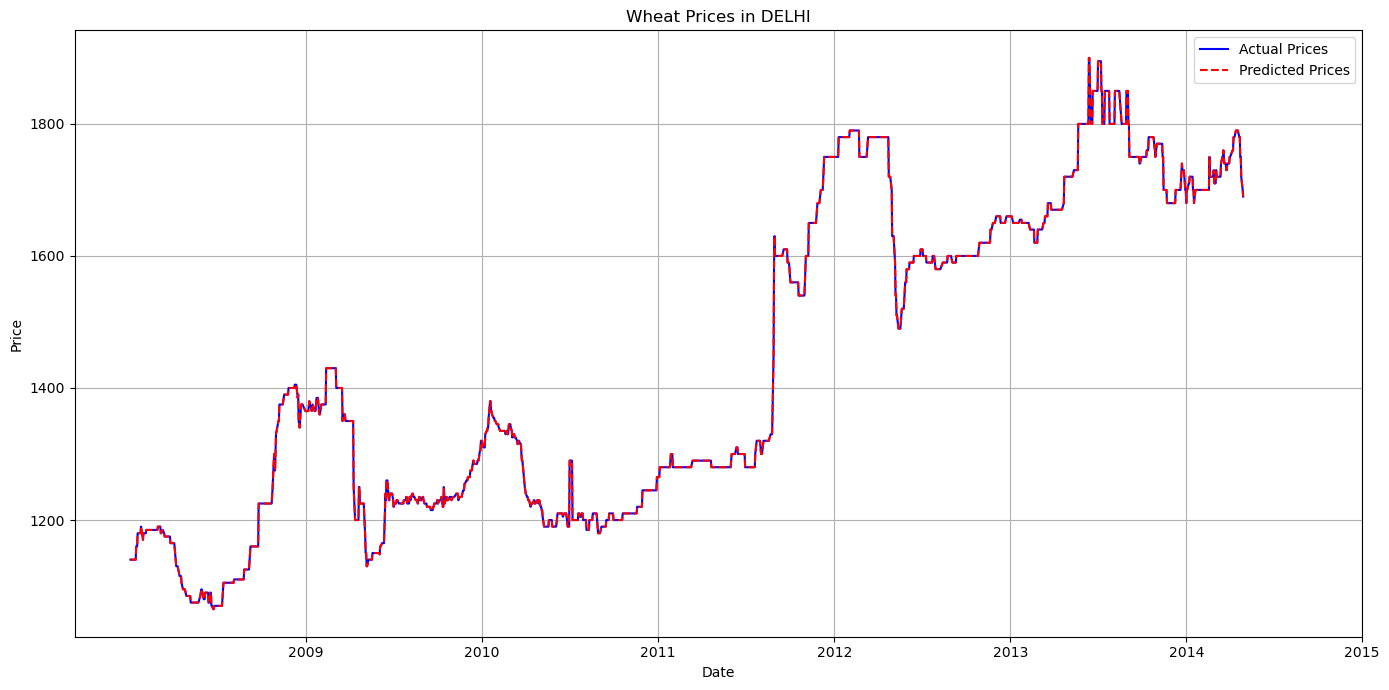

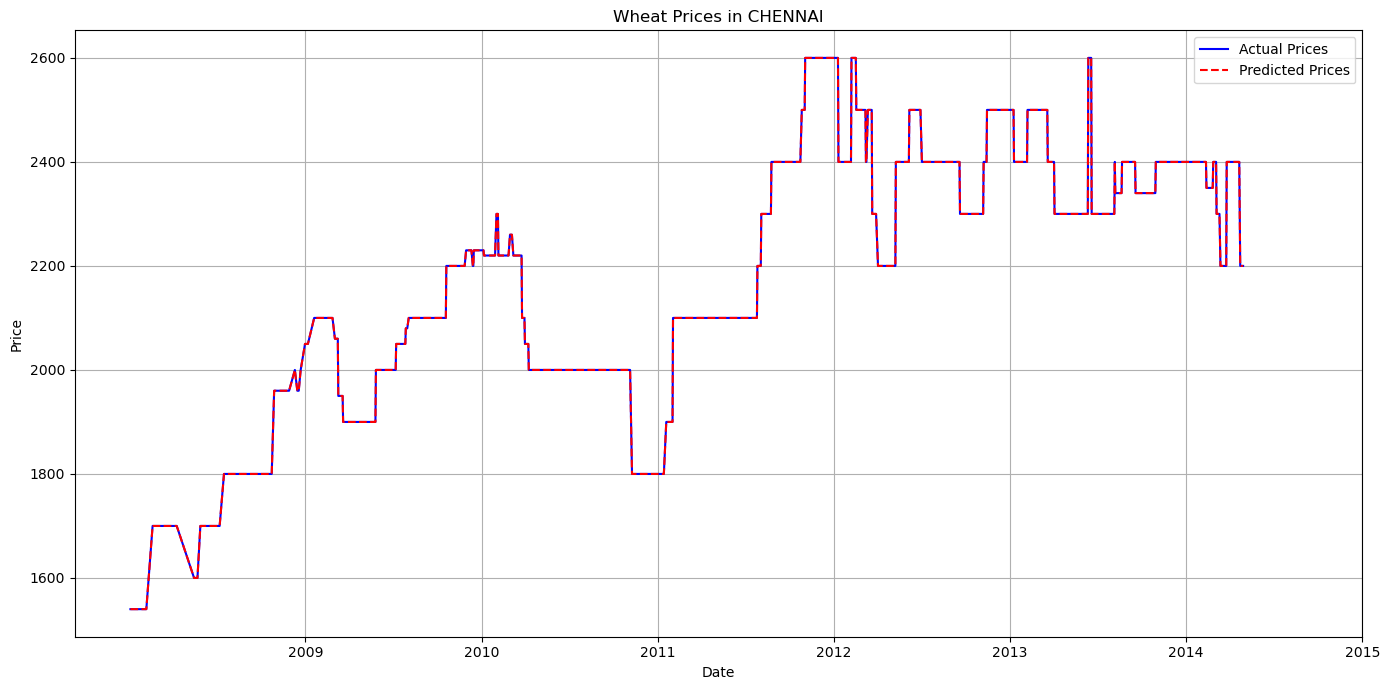

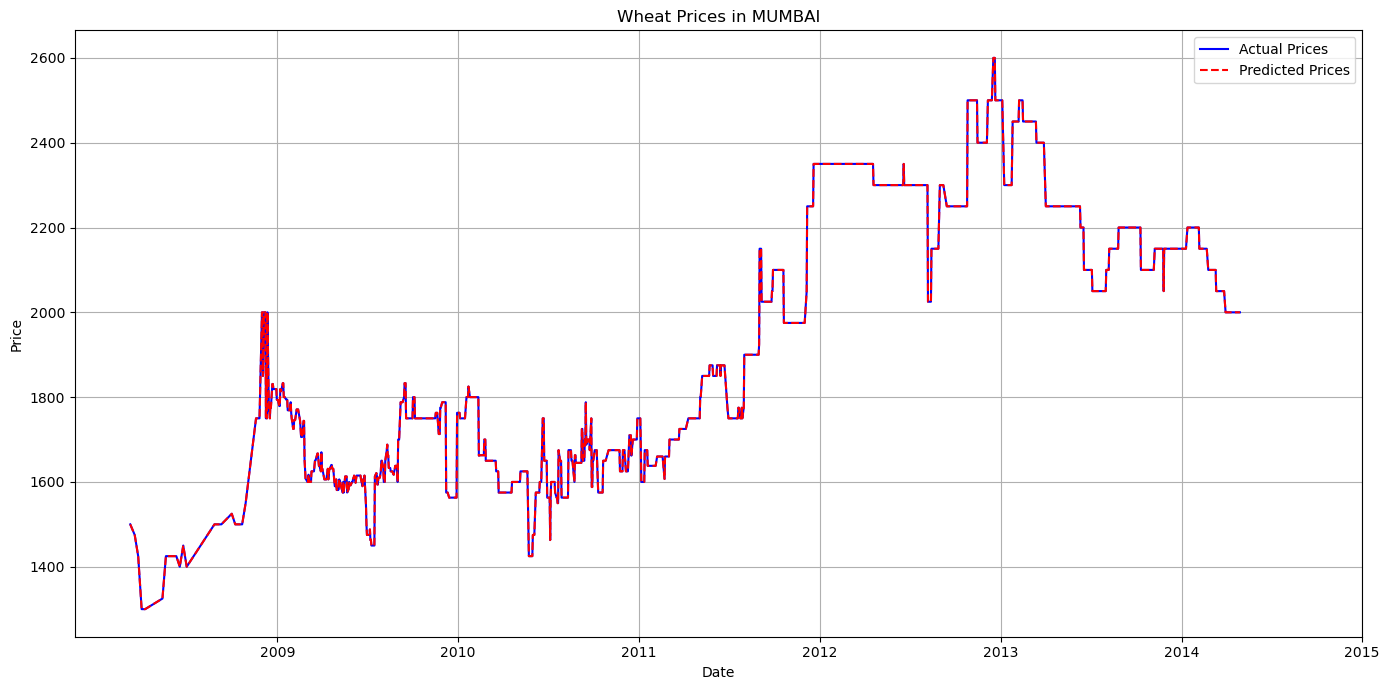

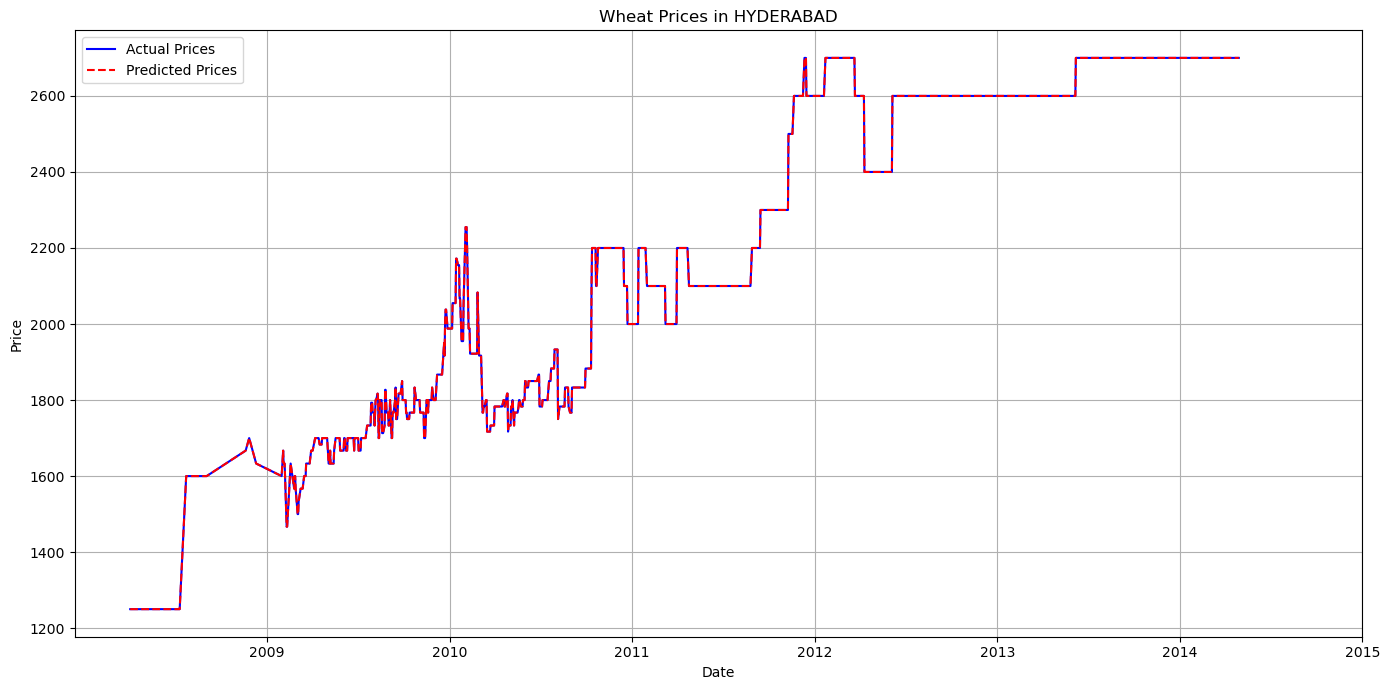

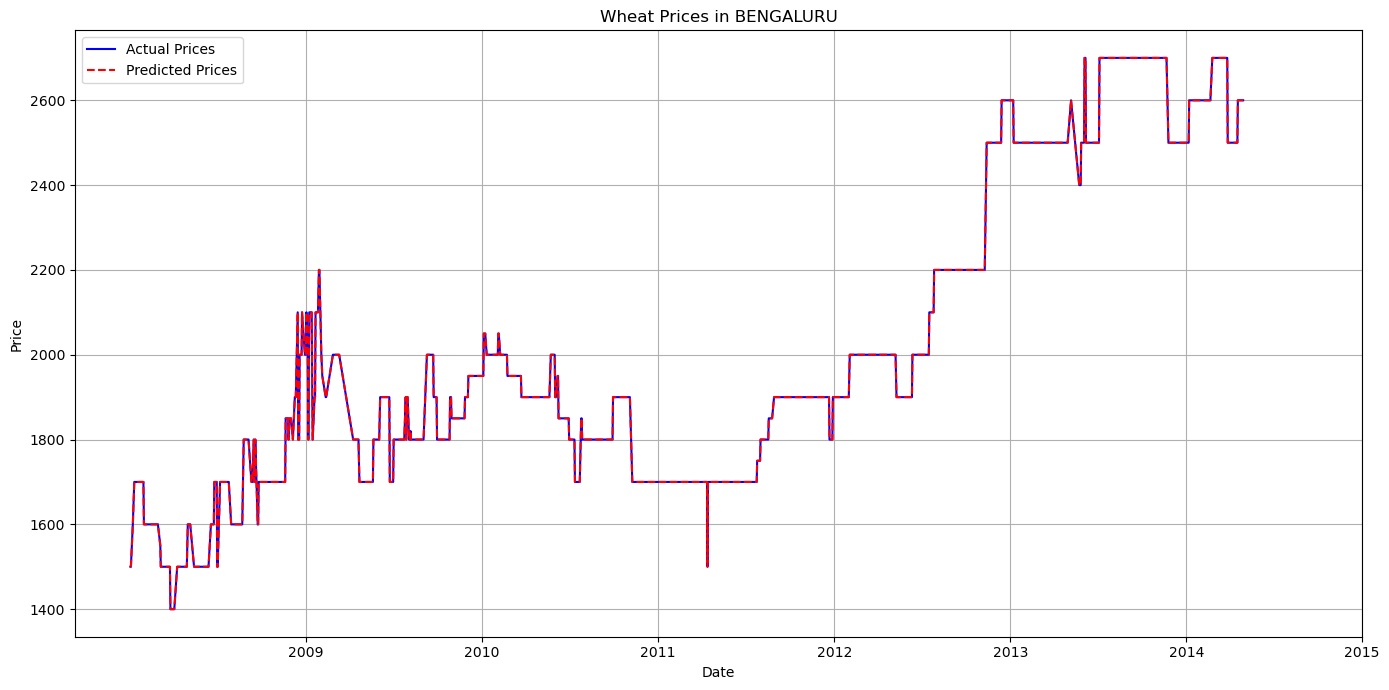

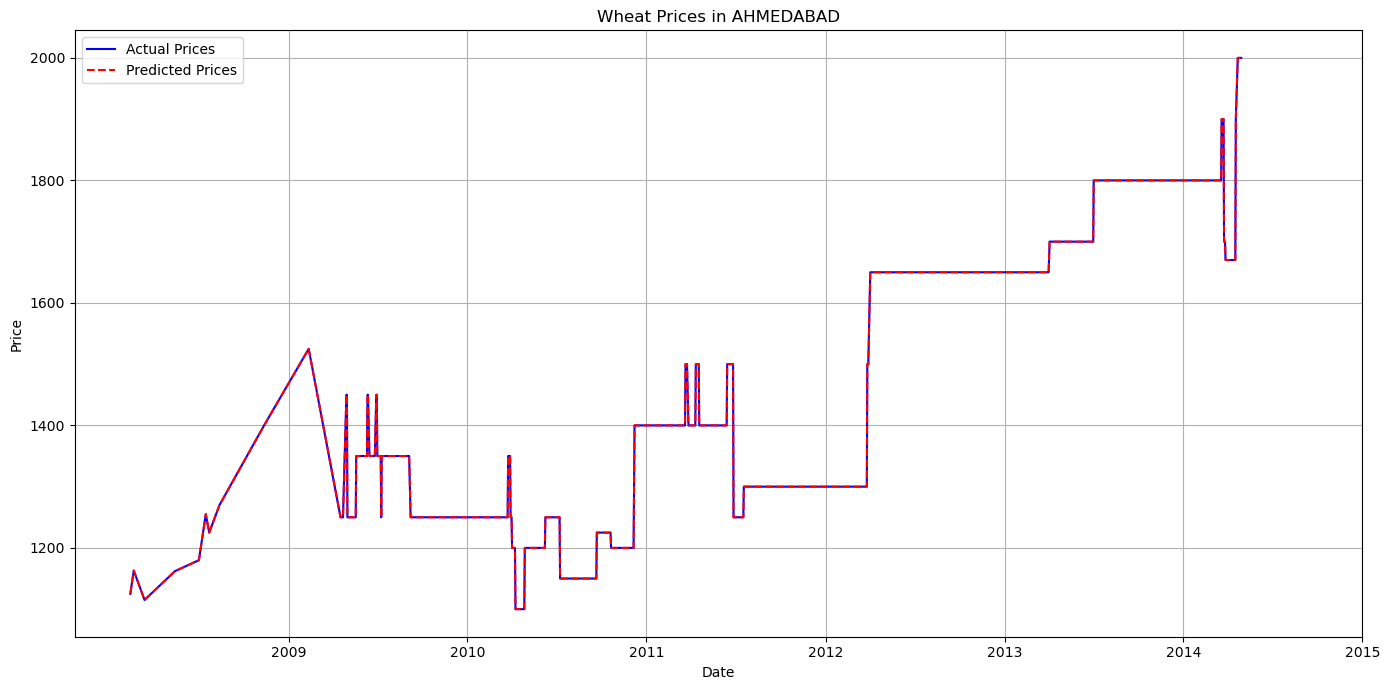

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the combined dataset
combined_df = pd.read_excel('combined_wheat_weather_data_by_month.xlsx')

# Check the columns
print("Columns in dataset:", combined_df.columns)

# Convert 'date' to datetime format
combined_df['date'] = pd.to_datetime(combined_df['date'], format='%d-%m-%Y')

# Extract year from date for plotting
combined_df['year'] = combined_df['date'].dt.year

# Filter out cities with less dataset
city_counts = combined_df['centre'].value_counts()
cities_with_sufficient_data = city_counts[city_counts > 10].index  # Adjust threshold as needed

# Plot for each city with sufficient data
for city in cities_with_sufficient_data:
    city_data = combined_df[combined_df['centre'] == city]
    
    plt.figure(figsize=(14, 7))
    plt.plot(city_data['date'], city_data['price'], label='Actual Prices', color='blue')
    plt.plot(city_data['date'], city_data['price'], label='Predicted Prices', color='red', linestyle='--')  # Placeholder for predicted prices
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'Wheat Prices in {city}')
    plt.legend()
    plt.xticks(ticks=city_data['date'].dt.to_period('Y').unique(), labels=city_data['date'].dt.year.unique())
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [45]:
import pickle
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

def save_model_and_scalers(model, scaler_X, scaler_y, city_name):
    # Save the model
    model.save(f'{city_name}_model.h5')
    
    # Save the scalers
    with open(f'{city_name}_scaler_X.pkl', 'wb') as f:
        pickle.dump(scaler_X, f)
    
    with open(f'{city_name}_scaler_y.pkl', 'wb') as f:
        pickle.dump(scaler_y, f)

# Example usage after training
# save_model_and_scalers(model, scaler_X, scaler_y, city)


In [61]:
# Assuming you have trained your model for 'MUMBAI'
save_model_and_scalers(model, scaler_X, scaler_y, 'MUMBAI')


In [75]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import joblib
from sklearn.preprocessing import OneHotEncoder

def load_model_and_scalers(city):
    # Load the model for the given city
    model = load_model(f'{city}_model.h5')
    
    # Load the scalers
    scaler_X = joblib.load(f'{city}_scaler_X.pkl')
    scaler_y = joblib.load(f'{city}_scaler_y.pkl')
    
    return model, scaler_X, scaler_y

def predict_price(date, city, msp, rainfall, max_temp, min_temp):
    # Load model and scalers
    model, scaler_X, scaler_y = load_model_and_scalers(city)
    
    # Prepare the input DataFrame
    input_df = pd.DataFrame({
        'date': [date],
        'city': [city],  # Ensure city column is included
        'MSP': [msp],
        'rainfall': [rainfall],
        'max_temp': [max_temp],
        'min_temp': [min_temp]
    })
    
    # Ensure the date is in the correct format
    input_df['date'] = pd.to_datetime(input_df['date'], format='%d-%m-%Y')
    
    # Create the 'Month' column
    input_df['Month'] = input_df['date'].dt.to_period('M')
    
    # Aggregate data by month (mean values)
    input_df = input_df.groupby('Month').agg({
        'rainfall': 'mean',
        'max_temp': 'mean',
        'min_temp': 'mean',
        'MSP': 'mean'
    }).reset_index()

    # One-Hot Encode city
    enc = OneHotEncoder(sparse_output=False)  # Update to new parameter name
    city_encoded = enc.fit_transform([[city]])  # Ensure city is passed correctly
    
    # Prepare feature data (without the city)
    features = ['rainfall', 'max_temp', 'min_temp', 'MSP']
    input_data = input_df[features].values
    
    # Concatenate the city encoding with the other features
    input_data = np.concatenate((input_data, city_encoded), axis=1)
    
    # Ensure enough time steps for the model
    time_step = 30
    if input_data.shape[0] < time_step:
        padding = np.zeros((time_step - input_data.shape[0], input_data.shape[1]))
        input_data = np.vstack((padding, input_data))
    
    # Use only the most recent time_steps
    input_data = input_data[-time_step:]
    
    # Reshape for LSTM (batch_size, time_steps, features)
    input_data = np.reshape(input_data, (1, time_step, input_data.shape[1]))
    
    # Check shapes
    print("Input data shape:", input_data.shape)
    
    # Predict using the model
    scaled_price_pred = model.predict(input_data)
    price_pred = scaler_y.inverse_transform(scaled_price_pred)
    
    return price_pred[0][0]


# Example usage
try:    
    predicted_price = predict_price('10-01-2023', 'MUMBAI', 2125, 0.1, 39.4, 13.8)    
    print(f'Predicted Price: {predicted_price}')
except Exception as e:    
    print(f'An error occurred: {e}')

Input data shape: (1, 30, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Price: 1151.5269775390625
